##Setup

You will need to make a copy of this notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.

In [ ]:
#@title mount your Google Drive
#@markdown Your work will be stored in a folder called `cds_rl_2022` by default to prevent Colab instance timeouts from deleting your edits.

import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cds_rl_2022'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
    !mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cds_rl_2022'
if not os.path.exists(SYM_PATH):
    !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
#@title apt install requirements

#@markdown Run each section with Shift+Enter

#@markdown Double-click on section headers to show code.

!apt update 
!apt install -y --no-install-recommends \
        build-essential \
        curl \
        git \
        git-lfs \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        xvfb \
        python-opengl \
        ffmpeg

# set up git lfs
!git lfs install

In [ ]:
#@title install mujoco-py

%pip install free-mujoco-py

# Cythonizes pkg on the first run
import mujoco_py

### Clone/update repo

Now we need to clone the HW3 codebase. There are two options:

1. Git clone the [repository](https://github.com/pkuderov/mipt-rl-hw-2022.git), install requirements, start coding HW3. This's the only option if you haven't cloned the repo yet for HW1. 
    If you have the repo already cloned, it's better to follow the 2-nd option. Otherwise, you will need to move the old `rl_hw` folder first. But don't delete it - make sure you've kept the HW1 solution as you will need it for this assignment!

2. Use already cloned local repository in `rl_hw`. Save the HW1 solution to the separate branch, then git pull changes from the remote upstream to get HW3 codebase.

In [ ]:
#@title clone homework repo (option #1)
# %cd $SYM_PATH
# !git clone https://github.com/nortem/mipt-rl-hw-2022.git rl_hw
# %cd rl_hw

In [ ]:
#@title pull updated repo (option #2)
# Don't hesitate to update the script for yourself

# %cd $SYM_PATH/rl_hw
# # git commit before pulling
# !git checkout -b "hw2"
# !git add .
# !git commit -m "HW2 solution"
# !git checkout main

# # update
# !git pull

In [ ]:
%cd $SYM_PATH/rl_hw

/content/gdrive/My Drive/cds_rl_2022/rl_hw


In [ ]:
#@title install requirements (the same as for previous homeworks + gym[atari] is added)
%cd hw1
%pip install -r requirements.colab.txt
%pip install -e .

# also install hw3 package
%cd ../hw3
%pip install -e .

In [ ]:
#@title set up the Ms. Pacman environment

import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')

ATARI_PATH=f'{SYM_PATH}/Atari'

%pip install unrar
!unrar x Roms.rar
%mkdir $ATARI_PATH
%mv Roms.rar $ATARI_PATH
%mv 'HC ROMS' $ATARI_PATH
%mv 'ROMS' $ATARI_PATH
!python -m atari_py.import_roms $ATARI_PATH

In [ ]:
#@title set up virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

# For later
from hw3.infrastructure.colab_utils import (
    wrap_env,
    show_video
)

In [ ]:
#@title test virtual display

#@markdown If you see a video of a four-legged ant fumbling about, setup is complete!

import gym
import matplotlib
matplotlib.use('Agg')

env = wrap_env(gym.make("Ant-v2"))

observation = env.reset()
for i in range(10):
    env.render(mode='rgb_array')
    obs, rew, term, _ = env.step(env.action_space.sample() ) 
    if term:
        break;
            
env.close()
print('Loading video...')
show_video()

Loading video...


## Editing Code

To edit code, click the folder icon on the left menu. Navigate to the corresponding file (`cds_rl_2022/...`). Double click a file to open an editor. There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window). We sync your edits to Google Drive so that you won't lose your work in the event of an instance timeout, but you will need to re-mount your Google Drive and re-install packages with every new instance.

## Run DQN and Double DQN

In [ ]:
#@title imports
import os
import time

from hw3.infrastructure.rl_trainer import RL_Trainer
from hw3.agents.dqn_agent import DQNAgent
from hw3.infrastructure.dqn_utils import get_env_kwargs

In [ ]:
#@title runtime arguments

class Args:

    def __getitem__(self, key):
        return getattr(self, key)

    def __setitem__(self, key, val):
        setattr(self, key, val)

    def __contains__(self, key):
        return hasattr(self, key)

    env_name = 'MsPacman-v0' #@param ['MsPacman-v0', 'LunarLander-v3', 'PongNoFrameSkip-v4']
    exp_name = 'q3_dqn' #@param

    ## PDF will tell you how to set ep_len
    ## and discount for each environment
    ep_len = 200 #@param {type: "integer"}

    #@markdown batches and steps
    batch_size = 32 #@param {type: "integer"}
    eval_batch_size = 1000 #@param {type: "integer"}

    num_agent_train_steps_per_iter = 1 #@param {type: "integer"}

    num_critic_updates_per_agent_update = 1 #@param {type: "integer"}

    #@markdown Q-learning parameters
    double_q = False #@param {type: "boolean"}

    #@markdown system
    save_params = False #@param {type: "boolean"}
    no_gpu = False #@param {type: "boolean"}
    which_gpu = 0 #@param {type: "integer"}
    seed = 1 #@param {type: "integer"}

    #@markdown logging
    ## default is to not log video so
    ## that logs are small enough to be
    ## uploaded to gradscope
    video_log_freq =  -1 #@param {type: "integer"}
    scalar_log_freq =  10000#@param {type: "integer"}


args = Args()

## ensure compatibility with hw1 code
args['train_batch_size'] = args['batch_size']

if args['video_log_freq'] > 0:
    import warnings
    warnings.warn(
        '''\nLogging videos will make eventfiles too'''
        '''\nlarge for the autograder. Set video_log_freq = -1'''
        '''\nfor the runs you intend to submit.'''
    )

In [ ]:
#@title create directories for logging

def create_log_dir(args, data_path_sub=''):

    data_path = '/content/cds_rl_2022/hw3/data'+data_path_sub
    if not (os.path.exists(data_path)):
        os.makedirs(data_path)
    logdir = args.exp_name + '_' + args.env_name + '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
    logdir = os.path.join(data_path, logdir)
    args['logdir'] = logdir
    if not(os.path.exists(logdir)):
        os.makedirs(logdir)
    print("LOGGING TO: ", logdir)
    
# data_path = '/content/cds_rl_2022/rl_hw/hw3/data'

# if not (os.path.exists(data_path)):
#     os.makedirs(data_path)

# logdir = args.exp_name + '_' + args.env_name + '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
# logdir = os.path.join(data_path, logdir)
# args['logdir'] = logdir
# if not(os.path.exists(logdir)):
#     os.makedirs(logdir)

# print("LOGGING TO: ", logdir)


In [ ]:
#@title read_logs
from tensorflow.python.summary.summary_iterator import summary_iterator
def read_logs(filename, tag):
    info_tag = []
    for e in summary_iterator(filename):
        for v in e.summary.value:
            if v.tag == tag:
                info_tag.append(v.simple_value)
    return info_tag

In [ ]:
#@title Define Q-function trainer

class Q_Trainer(object):

    def __init__(self, params):
        self.params = params

        train_args = {
            'num_agent_train_steps_per_iter': params['num_agent_train_steps_per_iter'],
            'num_critic_updates_per_agent_update': params['num_critic_updates_per_agent_update'],
            'train_batch_size': params['batch_size'],
            'double_q': params['double_q'],
        }

        env_args = get_env_kwargs(params['env_name'])

        for k, v in env_args.items():
            params[k] = v

        self.params['agent_class'] = DQNAgent
        self.params['agent_params'] = params
        self.params['train_batch_size'] = params['batch_size']
        self.params['env_wrappers'] = env_args['env_wrappers']

        self.rl_trainer = RL_Trainer(self.params)

    def run_training_loop(self):
        self.rl_trainer.run_training_loop(
            self.params['num_timesteps'],
            collect_policy = self.rl_trainer.agent.actor,
            eval_policy = self.rl_trainer.agent.actor,
        )

In [ ]:
#@title plot
import matplotlib.pyplot as plt
%matplotlib inline

def plot_info(y, labels, y_label='', x_label='', koef=1):
    fig, ax = plt.subplots(figsize=(20, 10))
    for i in range(len(y)):
        ax.plot(list(range(len(y[i])))*koef, y[i], label=labels[i])
    ax.legend()
    ax.grid()
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_xlabel(x_label, fontsize=16)
    plt.show()


### Эксперимент

In [ ]:
args = Args()
args.exp_name = 'q1'
create_log_dir(args, '/q1_2')
trainer = Q_Trainer(args)
trainer.run_training_loop()

```
********** Iteration 1610000 ************

Training agent...

Beginning logging procedure...
Timestep 1610001
mean reward (100 episodes) 1532.900000
best mean reward 1599.700000
running time 13487.616885
Train_EnvstepsSoFar : 1610001
Train_AverageReturn : 1532.9
Train_BestReturn : 1599.7
TimeSinceStart : 13487.616884946823
Training Loss : 0.25639164447784424
Done logging...
```

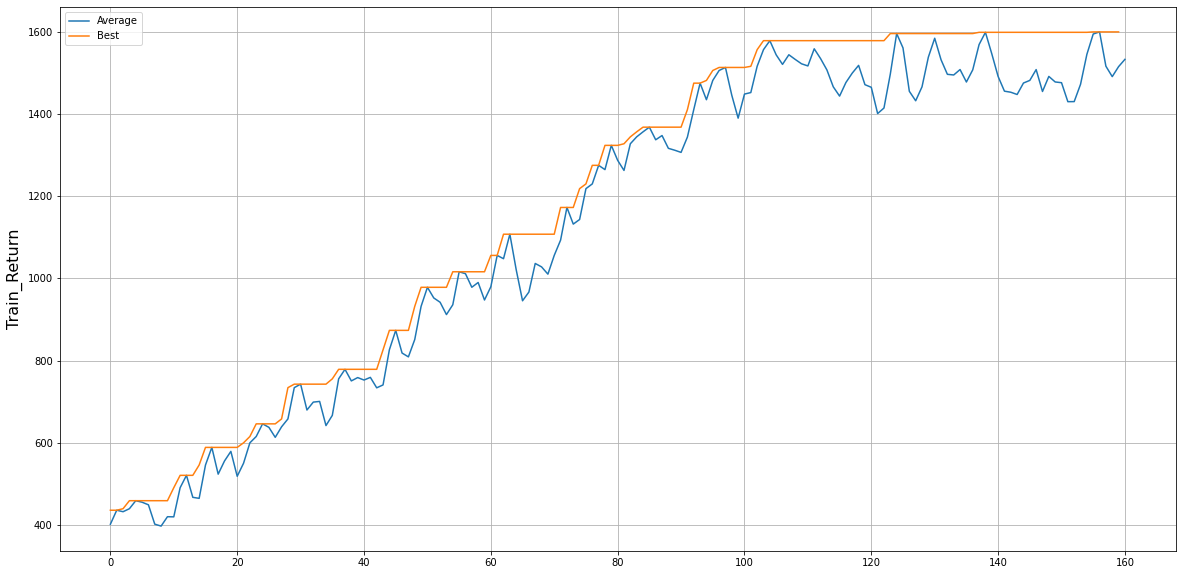

In [ ]:
filename = '/content/cds_rl_2022/hw3/data/q1_2/q1_MsPacman-v0_24-05-2022_07-23-26/events.out.tfevents.1653377006.0d2644e26876'
tag1 = 'Train_AverageReturn'
X_1 = read_logs(filename, tag1)
tag2 = 'Train_BestReturn'
X_2 = read_logs(filename, tag2)
plot_info([X_1, X_2], ['Av', 'B'], y_label='Train_Return')